Train: (300, 7) (300, 1)
Val: (100, 7) (100, 1)
Test: (100, 7) (100, 1)


,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid
92,137059,1,3,11,1,3,0.0
45,138353,3,1,12,4,3,1.0
313,124940,1,3,6,7,3,1.0
46,138353,2,1,12,3,11,0.0
185,134879,1,1,9,1,10,0.0


,count,mean,std,min,25%,50%,75%,max
Page total likes,300.0,123511.376667,16211.773474,81370.0,113028.00,130195.5,136393.0,139441.0
Type,300.0,1.216667,0.580959,1.0,1.00,1.0,1.0,4.0
Category,300.0,1.896667,0.849546,1.0,1.00,2.0,3.0,3.0
Post Month,300.0,7.106667,3.306316,1.0,4.00,7.0,10.0,12.0
Post Weekday,300.0,4.180000,2.015226,1.0,2.75,4.0,6.0,7.0
Post Hour,300.0,7.546667,4.348662,1.0,3.00,8.0,11.0,22.0
Paid,299.0,0.290970,0.454971,0.0,0.00,0.0,1.0,1.0


,count,mean,std,min,25%,50%,75%,max
Lifetime Post Consumers,300.0,827.986667,1009.102992,9.0,321.25,543.5,1008.75,11328.0


Desv-Est y-original: 1007.420
Desv-Est y-logaritmo: 0.906


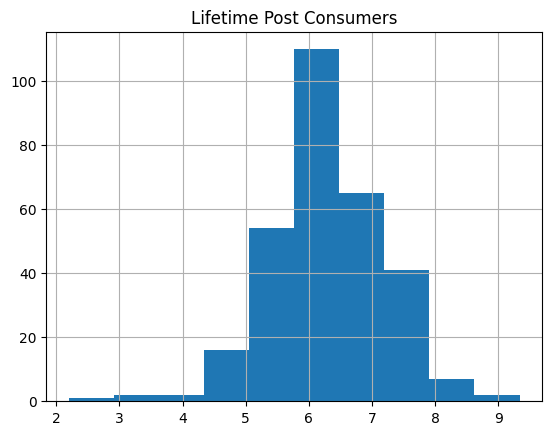

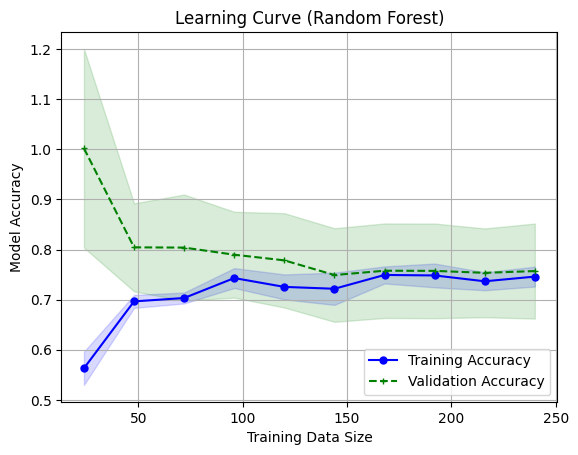

Error RMSE(Test) de Random Forest: 0.764


In [ ]:
# Importación de librerías
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings

from sklearn.model_selection import train_test_split, RepeatedKFold, cross_validate, learning_curve, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore', category=UserWarning)

DIR = "./"  # o especifica la ruta donde se encuentra dataset_Facebook.csv
os.chdir(DIR)

# Se intenta leer el dataset. Ajusta el separador si es necesario.
# Se comenta la primera lectura y se utiliza la que emplea ';' como separador.
# data = pd.read_csv("dataset_Facebook.csv", sep=' ', header='infer')
data = pd.read_csv("dataset_Facebook.csv", sep=';', header='infer')

# Se separan los datos de entrada y la variable de salida:
X = data.iloc[:, 0:7]   # Las primeras 7 columnas son las variables de entrada.
y = data[['Lifetime Post Consumers']]  # Se trabaja con esta variable de salida.

# Renombramos los niveles de "Type" para que sean numéricos:
X['Type'] = X['Type'].map({'Photo': 1, 'Status': 2, 'Link': 3, 'Video': 4})

# Particionamos en Train, Validation y Test en proporciones 60-20-20:
Xtrain, Xtv, ytrain, ytv = train_test_split(X, y, train_size=0.6, shuffle=True, random_state=5)
Xval, Xtest, yval, ytest = train_test_split(Xtv, ytv, test_size=0.5, shuffle=True, random_state=7)

print('Train:', Xtrain.shape, ytrain.shape)
print('Val:', Xval.shape, yval.shape)
print('Test:', Xtest.shape, ytest.shape)

# Visualizamos algunas muestras y descripciones:
display(Xtrain.head())
display(Xtrain.describe().T)
display(ytrain.describe().T)

# Transformación logarítmica de la variable de salida para que tenga distribución más acampanada:
ytrainlog = np.log(ytrain)
ytrainlog.hist();  # Histograma de la variable transformada

# Aplicamos la transformación logarítmica a Val y Test:
yvallog = np.log(yval)
ytestlog = np.log(ytest)

# Transformaciones mínimas para datos perdidos:
# Pipeline para la variable numérica:
num_pipe = Pipeline(steps=[('numImp', SimpleImputer(strategy='median'))])
num_pipe_nombres = [0]   # Ejemplo: ['Page total likes']

# Pipeline para variables ordinales:
ord_pipe = Pipeline(steps=[('OrdImp', SimpleImputer(strategy='most_frequent')),
                             ('Ordfun', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])
ord_pipe_nombres = [3, 4, 5]   # Ejemplo: ['Post Month', 'Post Weekday', 'Post Hour']

# Pipeline para variables nominales:
nom_pipe = Pipeline(steps=[('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))])
nom_pipe_nombres = [1, 2, 6]   # Ejemplo: ['Type', 'Category', 'Paid']

# Se combinan las transformaciones:
columnasTransformer = ColumnTransformer(transformers=[
    ('numpow', num_pipe, num_pipe_nombres),
    ('catOrd', ord_pipe, ord_pipe_nombres),
    ('catNom', nom_pipe, nom_pipe_nombres)
], remainder='passthrough')

# Ajuste y transformación en Train, Val y Test:
XtrainFit = columnasTransformer.fit(Xtrain)
XtrainT = XtrainFit.transform(Xtrain)
XvalT   = XtrainFit.transform(Xval)
XtestT  = XtrainFit.transform(Xtest)

# Visualización de estadísticas de la variable de salida:
print('Desv-Est y-original: %.3f' % ytrain.values.std())
print('Desv-Est y-logaritmo: %.3f' % ytrainlog.values.std())

## ---------------------------
## Ejercicio 3
## ---------------------------
# Ajuste del modelo de Random Forest para evitar subentrenamiento o sobreentrenamiento.

# ++++++++++++++ Ajustes del modelo Random Forest ++++++++++++++++++++++++++++++
elmodelo_RF = RandomForestRegressor(oob_score=True, n_estimators=300, min_samples_split=3, 
                                    max_depth=2, criterion='absolute_error', ccp_alpha=0.001, 
                                    bootstrap=True, random_state=42)
# +++++++++++++ Fin de ajustes +++++++++++++++++++++++++++++

mipipe = Pipeline(steps=[('ct', columnasTransformer), ('m', elmodelo_RF)])

# Cálculo de la curva de aprendizaje:
train_sizes, train_scores, val_scores = learning_curve(
    estimator=mipipe,
    X=XtrainT,
    y=np.ravel(ytrainlog),
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Cálculo del RMSE:
rmse_train_scores = np.sqrt(-train_scores)
rmse_val_scores = np.sqrt(-val_scores)

train_mean = np.mean(rmse_train_scores, axis=1)
train_std = np.std(rmse_train_scores, axis=1)
val_mean = np.mean(rmse_val_scores, axis=1)
val_std = np.std(rmse_val_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, val_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.15, color='green')
plt.title('Learning Curve (Random Forest)')
plt.xlabel('Training Data Size')
plt.ylabel('Model Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

# Cálculo del RMSE en el conjunto de Test:
mipipe.fit(Xtrain, np.ravel(ytrainlog))
yhattest_RF = mipipe.predict(Xtest)
print('Error RMSE(Test) de Random Forest: %.3f' % np.sqrt(mean_squared_error(np.ravel(ytestlog), yhattest_RF)))

## ---------------------------
## Ejercicio 4: XGBoost, SVM y MLP
## ---------------------------
# Se define el modelo XGBoost y se realiza la búsqueda de hiperparámetros.

# Modelo XGBoost inicial:
elmodelo_XGB = XGBRegressor(objective='reg:squarederror', random_state=42)

# Definir nuevamente el transformer (se utiliza el mismo que antes)
columnasTransformer = ColumnTransformer(transformers=[
    ('numpow', Pipeline(steps=[('numImp', SimpleImputer(strategy='median'))]), [0]),
    ('catOrd', Pipeline(steps=[('OrdImp', SimpleImputer(strategy='most_frequent')),
                                ('Ordfun', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))]),
     [3, 4, 5]),
    ('catNom', Pipeline(steps=[('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))]), [1, 2, 6])
], remainder='passthrough')

# Pipeline para XGBoost:
mipipe_xgb = Pipeline(steps=[('ct', columnasTransformer), ('m', elmodelo_XGB)])

# +++++++++++++ Búsqueda de hiperparámetros para XGBoost ++++++++++++++++++++++++++++++
param_grid = {
    'm__n_estimators': [50, 100, 200, 300],
    'm__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'm__max_depth': [3, 5, 7, 9],
    'm__min_child_weight': [1, 3, 5],
    'm__subsample': [0.8, 0.9, 1.0],
    'm__colsample_bytree': [0.8, 0.9, 1.0],
    'm__reg_alpha': [0.0, 0.1, 0.5, 0.8],
    'm__reg_lambda': [0.0, 0.1, 0.5, 0.8]
}

grid_search_xgb = GridSearchCV(estimator=mipipe_xgb, param_grid=param_grid, cv=5,
                               scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_xgb.fit(XtrainT, np.ravel(ytrainlog))
print("Mejores hiperparámetros para XGBoost:", grid_search_xgb.best_params_)
# +++++++++++++ Fin búsqueda hiperparámetros +++++++++++++++++++++++++++++

# Curva de aprendizaje para XGBoost:
train_sizes_xgb, train_scores_xgb, val_scores_xgb = learning_curve(
    estimator=grid_search_xgb.best_estimator_,
    X=XtrainT,
    y=np.ravel(ytrainlog),
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

rmse_train_scores_xgb = np.sqrt(-train_scores_xgb)
rmse_val_scores_xgb = np.sqrt(-val_scores_xgb)

train_mean_xgb = np.mean(rmse_train_scores_xgb, axis=1)
train_std_xgb = np.std(rmse_train_scores_xgb, axis=1)
val_mean_xgb = np.mean(rmse_val_scores_xgb, axis=1)
val_std_xgb = np.std(rmse_val_scores_xgb, axis=1)

plt.figure()
plt.plot(train_sizes_xgb, train_mean_xgb, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes_xgb, train_mean_xgb + train_std_xgb, train_mean_xgb - train_std_xgb, alpha=0.15, color='blue')
plt.plot(train_sizes_xgb, val_mean_xgb, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes_xgb, val_mean_xgb + val_std_xgb, val_mean_xgb - val_std_xgb, alpha=0.15, color='green')
plt.title('Learning Curve (XGBoost)')
plt.xlabel('Training Data Size')
plt.ylabel('Model Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

# Ajuste final para XGBoost con hiperparámetros encontrados:
elmodelo_XGB = XGBRegressor(objective='reg:squarederror',
                            colsample_bytree=0.8,
                            learning_rate=0.1,
                            max_depth=3,
                            min_child_weight=5,
                            n_estimators=50,
                            reg_alpha=0.1,
                            reg_lambda=0.0,
                            subsample=0.9,
                            random_state=42)
mipipe_xgb = Pipeline(steps=[('ct', columnasTransformer), ('m', elmodelo_XGB)])
mipipe_xgb.fit(Xtrain, np.ravel(ytrainlog))
yhattest_xgb = mipipe_xgb.predict(Xtest)
print('Error RMSE(Test) de XGBoost: %.3f' % np.sqrt(mean_squared_error(np.ravel(ytestlog), yhattest_xgb)))

# Modelo SVM
elmodelo_SVM = SVR(kernel='rbf')
mipipe_svm = Pipeline(steps=[('ct', columnasTransformer), ('m', elmodelo_SVM)])

# Búsqueda de hiperparámetros para SVM:
param_grid_svm = {
    'm__kernel': ['linear', 'poly', 'rbf'],
    'm__degree': [2, 3, 4],
    'm__coef0': [0.0, 0.1, 0.5, 1.0]
}

grid_search_svm = GridSearchCV(estimator=mipipe_svm, param_grid=param_grid_svm, cv=5,
                               scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_svm.fit(XtrainT, np.ravel(ytrainlog))
print("Mejores hiperparámetros para SVM:", grid_search_svm.best_params_)

# Curva de aprendizaje para SVM:
train_sizes_svm, train_scores_svm, val_scores_svm = learning_curve(
    estimator=grid_search_svm.best_estimator_,
    X=XtrainT,
    y=np.ravel(ytrainlog),
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

rmse_train_scores_svm = np.sqrt(-train_scores_svm)
rmse_val_scores_svm = np.sqrt(-val_scores_svm)

train_mean_svm = np.mean(rmse_train_scores_svm, axis=1)
train_std_svm = np.std(rmse_train_scores_svm, axis=1)
val_mean_svm = np.mean(rmse_val_scores_svm, axis=1)
val_std_svm = np.std(rmse_val_scores_svm, axis=1)

plt.figure()
plt.plot(train_sizes_svm, train_mean_svm, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes_svm, train_mean_svm + train_std_svm, train_mean_svm - train_std_svm, alpha=0.15, color='blue')
plt.plot(train_sizes_svm, val_mean_svm, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes_svm, val_mean_svm + val_std_svm, val_mean_svm - val_std_svm, alpha=0.15, color='green')
plt.title('Learning Curve (SVM)')
plt.xlabel('Training Data Size')
plt.ylabel('Model Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

# Ajuste final para SVM:
elmodelo_SVM = SVR(kernel='rbf', C=1000, gamma='scale', coef0=0.0, degree=2)
mipipe_svm = Pipeline(steps=[('ct', columnasTransformer), ('m', elmodelo_SVM)])
mipipe_svm.fit(Xtrain, np.ravel(ytrainlog))
yhattest_svm = mipipe_svm.predict(Xtest)
print('Error RMSE(Test) de SVM: %.3f' % np.sqrt(mean_squared_error(np.ravel(ytestlog), yhattest_svm)))

# Modelo MLP
elmodelo_MLP = MLPRegressor(random_state=42)
mipipe_mlp = Pipeline(steps=[('ct', columnasTransformer), ('m', elmodelo_MLP)])

# Búsqueda de hiperparámetros para MLP:
param_grid_mlp = {
    'm__hidden_layer_sizes': [(50, 25), (100, 50), (200, 100)],
    'm__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'm__solver': ['lbfgs', 'adam'],
    'm__alpha': [0.0001, 0.001, 0.01],
    'm__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'm__max_iter': [100, 200, 300]
}

grid_search_mlp = GridSearchCV(estimator=mipipe_mlp, param_grid=param_grid_mlp, cv=5,
                               scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_mlp.fit(XtrainT, np.ravel(ytrainlog))
print("Mejores hiperparámetros para MLP:", grid_search_mlp.best_params_)

# Curva de aprendizaje para MLP:
train_sizes_mlp, train_scores_mlp, val_scores_mlp = learning_curve(
    estimator=grid_search_mlp.best_estimator_,
    X=XtrainT,
    y=np.ravel(ytrainlog),
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

rmse_train_scores_mlp = np.sqrt(-train_scores_mlp)
rmse_val_scores_mlp = np.sqrt(-val_scores_mlp)

train_mean_mlp = np.mean(rmse_train_scores_mlp, axis=1)
train_std_mlp = np.std(rmse_train_scores_mlp, axis=1)
val_mean_mlp = np.mean(rmse_val_scores_mlp, axis=1)
val_std_mlp = np.std(rmse_val_scores_mlp, axis=1)

plt.figure()
plt.plot(train_sizes_mlp, train_mean_mlp, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes_mlp, train_mean_mlp + train_std_mlp, train_mean_mlp - train_std_mlp, alpha=0.15, color='blue')
plt.plot(train_sizes_mlp, val_mean_mlp, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes_mlp, val_mean_mlp + val_std_mlp, val_mean_mlp - val_std_mlp, alpha=0.15, color='green')
plt.title('Learning Curve (MLP)')
plt.xlabel('Training Data Size')
plt.ylabel('Model Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

# Ajuste final para MLP:
elmodelo_MLP = MLPRegressor(activation='tanh',
                            alpha=0.0001,
                            hidden_layer_sizes=(200, 100),
                            learning_rate='constant',
                            max_iter=100,
                            solver='adam',
                            random_state=42)
mipipe_mlp = Pipeline(steps=[('ct', columnasTransformer), ('m', elmodelo_MLP)])
mipipe_mlp.fit(Xtrain, np.ravel(ytrainlog))
yhattest_mlp = mipipe_mlp.predict(Xtest)
print('Error RMSE(Test) de MLP: %.3f' % np.sqrt(mean_squared_error(np.ravel(ytestlog), yhattest_mlp)))
